In [164]:
import numpy as np
import matplotlib.pyplot as pt
import pandas as pd
from pandas import Series
import seaborn as sb
import warnings
from patsy import dmatrices
from sklearn.preprocessing import  Imputer
warnings.filterwarnings('ignore')
%matplotlib inline

#import the dataset

dataSet  = pd.read_csv("D:/Hackethon/LoanPrediction/train.csv",na_values=["NaN","nan"," "])

dataSet1  = pd.read_csv("D:/Hackethon/LoanPrediction/test.csv",na_values=["NaN","nan"," "])
datasetNew =  dataSet
datasetNew1 = dataSet1
#Finding the NA VAlues
print datasetNew.isnull().sum()
#below is the missing value count
# Loan_ID               0
# Gender               13
# Married               3
# Dependents           15
# Education             0
# Self_Employed        32
# ApplicantIncome       0
# CoapplicantIncome     0
# LoanAmount           22
# Loan_Amount_Term     14
# Credit_History       50
# Property_Area         0
# Loan_Status           0

# alot of missing values mostly in categorical fields except in LoanAmount


# remove first var which is loan ID
datasetNew = datasetNew.drop("Loan_ID",1)

print datasetNew.shape
datasetNew.fillna("NA",inplace=True)

# First of all we will try with summaries
#Let us aggregate by gender and see the proportion of categories
def calcCat(x):
    return Series(dict(TotalRecords = x["Loan_Status"].count()))
GenTable = datasetNew.groupby("Gender").apply(calcCat)
print GenTable
#         TotalRecords
# Gender              
# Female           112
# Male             489
# NA                13

# find the proportion
GenTable["prcntOfTotal"] = GenTable["TotalRecords"]/614
print GenTable
# Around 2 percent of the observations are missing, if we impute these by mode all will be replaced by gender Male which is 80%
#of the total, so we may want to keep it on hold and go with the multivariate imputation

#Do the same for Married
MarTable = datasetNew.groupby("Married").apply(calcCat)
MarTable["prcntOfTotal"] = MarTable["TotalRecords"]/614
print MarTable


DepTable = datasetNew.groupby("Dependents").apply(calcCat)
DepTable["prcntOfTotal"] = DepTable["TotalRecords"]/614
print DepTable
# in dependents we see the factor 3+, better replace it with 3 or 4. here we try 3
datasetNew["Dependents"] = datasetNew["Dependents"].apply(lambda x: "3" if x=="3+" else x )
datasetNew1["Dependents"] = datasetNew1["Dependents"].apply(lambda x: "3" if x=="3+" else x )
DepTable = datasetNew.groupby("Dependents").apply(calcCat)
DepTable["prcntOfTotal"] = DepTable["TotalRecords"]/614
print DepTable
#3+ has been replaced with 3

#Still we see that only 8% has 3 dependents and 2 % are missing , we can think about merging these two, but let's hold this thought.


EduTable = datasetNew.groupby("Education").apply(calcCat)
EduTable["prcntOfTotal"] = EduTable["TotalRecords"]/614
print EduTable


EmpTable = datasetNew.groupby("Self_Employed").apply(calcCat)
EmpTable["prcntOfTotal"] = EmpTable["TotalRecords"]/614
print EmpTable
#only 13 % of non missing data are self employed

LATTable = datasetNew.groupby("Loan_Amount_Term").apply(calcCat)
LATTable["prcntOfTotal"] = LATTable["TotalRecords"]/614
print LATTable

# We see that only two type of terms represent 91% of population
#Rest 8 pus NA values add up to only 9 %, so we can conver them to category other
datasetNew["Loan_Amount_Term"] = datasetNew["Loan_Amount_Term"].astype(str).apply(lambda x: x if x=="360.0" or x=="180.0" else "Others")


LATTable = datasetNew.groupby("Loan_Amount_Term").apply(calcCat)
LATTable["prcntOfTotal"] = LATTable["TotalRecords"]/614
print LATTable

CHTable = datasetNew.groupby("Credit_History").apply(calcCat)
CHTable["prcntOfTotal"] = CHTable["TotalRecords"]/614
print CHTable
# Around 77 % of applicants have good credit history and for 8 %  it is missing, we must check the output variable distribution if it follows the same logic
LSTable = datasetNew.groupby("Loan_Status").apply(calcCat)
LSTable["prcntOfTotal"] = LSTable["TotalRecords"]/614
print LSTable
#Around 69% applicants got thir loans approved, I sense some corelation bw credit history and Loan Status. It is just a hunch
# let's try tables
LSTable1 = pd.crosstab(index = datasetNew["Loan_Status"],columns="count")
LSTable1["prop"] = LSTable1/LSTable1.sum()
print LSTable1

#A two way table bw Loan_Status and credithistory
bTable = pd.crosstab(index=datasetNew["Loan_Status"],columns=datasetNew["Credit_History"],margins=True)
bTable.index = ["No","Yes","ColTotal"]
bTable.columns  =["Bad","good","NA","rowtotals"]
print(bTable)
#           Bad  good  NA  rowtotals
# No         82    97  13        192
# Yes         7   378  37        422
# ColTotal   89   475  50        614

# to se the percentage as well

print bTable/bTable.ix["ColTotal"]


#So, if we take a closer look, we find that there is indeed a strong relationship between credit history and Loan_status
#Excluding missing data, we have found that if the credit history is bad i.e. 0, u generally don't get the loan, like 92% times
#you also get a loan for good credit history like 80% of times
#almost 74 % of NA's got Loans
#we can use this informaton to impute" credit history
datasetNew["Credit_History"] = datasetNew["Credit_History"].astype(str)
datasetNew.loc[(datasetNew.Credit_History=="NA") & (datasetNew.Loan_Status=="Y"),"Credit_History"] = "1.0"
datasetNew.loc[(datasetNew.Credit_History=="NA") & (datasetNew.Loan_Status=="N"),"Credit_History"] = "0.0"


   
bTable = pd.crosstab(index=datasetNew["Loan_Status"],columns=datasetNew["Credit_History"],margins=True)
bTable.index = ["No","Yes","ColTotal"]
bTable.columns  =["Bad","good","rowtotals"]
print(bTable)

#no more missing values in credit history
print datasetNew.dtypes
#plot property area
areatable = pd.crosstab(index=datasetNew["Property_Area"],columns="count")
print areatable/areatable.sum()
print areatable
#plot property area with loan status
nt = pd.crosstab(index=datasetNew["Property_Area"],columns=datasetNew["Loan_Status"],margins=True)
print nt
#let's see the proportions as well
nt.index = ["Rural","semiUrban","urban","colSum"]
print nt.T/nt["All"]
#If we look closely we find that loan approval ration is high for SemiYrban propert areas i.e. 77%
#let's look at Loan amount term and Loan_status
LTLN = pd.crosstab(index=datasetNew["Loan_Amount_Term"],columns=datasetNew["Loan_Status"],margins=True)
print LTLN
# term 360 is dominant , let's look at the proportions
print LTLN/LTLN.ix["All"]
#As we suspected ,it is clear that term 360 is dominating factor in both approved and rejected class, let's see the row wise proportion i.e. proportion for each term seperately
print LTLN.T/LTLN["All"]
#We see that the proportions of approval and rejection is almost same among all
#terms, for 30 it is bit higher, we can make an assumption that with higher term, chances of getting the loan increase.
#since Loan term and property area  and credit history seem like having good relation with Loan status, we can also think about the interaction terms

#Loan Status and Self_Employed
nt = pd.crosstab(index=datasetNew["Self_Employed"],columns=datasetNew["Loan_Status"],margins=True)
print nt
#let's see the proportions as well

print nt.T/nt["All"]
#After considering the distribution of self_employed variable with LoanStatus, we have found that approval and rejection ratios are same across the categories
# we can either take it out from equation or keep it for initial model fitting to check interaction effects
# the NA valus can be converted or imputed based on the below logic
datasetNew["Self_Employed"] = datasetNew["Self_Employed"].astype(str)
datasetNew.loc[(datasetNew.Self_Employed=="NA") & (datasetNew.Loan_Status =="N"),"Self_Employed"] = "No"
datasetNew.loc[(datasetNew.Self_Employed=="NA") & (datasetNew.Loan_Status =="Y"),"Self_Employed"] = "Yes"
nt = pd.crosstab(index=datasetNew["Self_Employed"],columns=datasetNew["Loan_Status"],margins=True)
print nt
print nt.T/nt["All"]


#Loan Status and Education
nt = pd.crosstab(index=datasetNew["Education"],columns=datasetNew["Loan_Status"],margins=True)
print nt
#let's see the proportions as well

print nt.T/nt["All"]
# there is a 10 % difference in rejection ratio b/w  Graduate and not graduate.
#means if you are not a graduate, loan rejection ratio is higher

#Loan Status and Gender
nt = pd.crosstab(index=datasetNew["Gender"],columns=datasetNew["Loan_Status"],margins=True)
print nt
#let's see the proportions as well

print nt.T/nt["All"]

#ratios seem same bw male and female, approval ratio a bit higher for Males, 

#Loan Status and Married
nt = pd.crosstab(index=datasetNew["Married"],columns=datasetNew["Loan_Status"],margins=True)
print nt
#let's see the proportions as well

print nt.T/nt["All"]
#ratios seem same bw married and unmarried, approval ratio a bit higher for Married, 

#Loan Status and Dependents
nt = pd.crosstab(index=datasetNew["Dependents"],columns=datasetNew["Loan_Status"],margins=True)
print nt
#let's see the proportions as well

print nt.T/nt["All"]
#ratios seem same bw married and unmarried, approval ratio a bit higher for Married, 
#   

print datasetNew.dtypes
#let's analyze loanAmount



Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
(614, 12)
        TotalRecords
Gender              
Female           112
Male             489
NA                13
        TotalRecords  prcntOfTotal
Gender                            
Female           112      0.182410
Male             489      0.796417
NA                13      0.021173
         TotalRecords  prcntOfTotal
Married                            
NA                  3      0.004886
No                213      0.346906
Yes               398      0.648208
            TotalRecords  prcntOfTotal
Dependents                            
0                    345      0.561889
1                    102      0.166124
2                    101      0.164495
3+        

0       NA
1      128
2       66
3      120
4      141
5      267
6       95
7      158
8      168
9      349
10      70
11     109
12     200
13     114
14      17
15     125
16     100
17      76
18     133
19     115
20     104
21     315
22     116
23     112
24     151
25     191
26     122
27     110
28      35
29     120
      ... 
584    146
585    172
586    104
587     70
588     94
589    106
590     56
591    205
592    292
593    142
594    260
595    110
596    187
597     88
598    180
599    192
600    350
601    155
602    128
603    172
604    496
605     NA
606    173
607    157
608    108
609     71
610     40
611    253
612    187
613    133
Name: LoanAmount, dtype: object
22
None
0
int32


(0, 741.66147340234079)

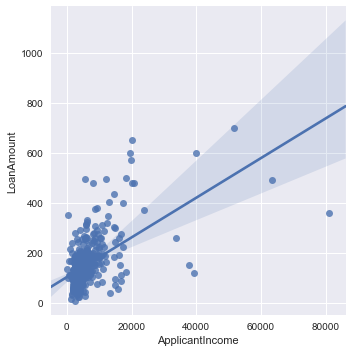

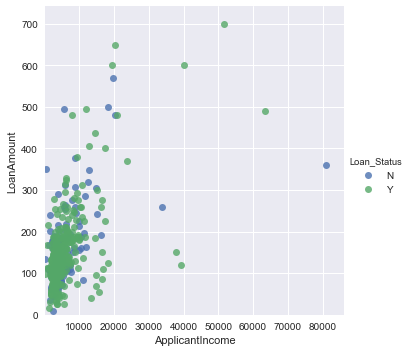

In [42]:
print datasetNew["LoanAmount"]
tb=pd.crosstab(index=datasetNew["LoanAmount"],columns="cout")
datasetNew.loc[(datasetNew["LoanAmount"]=="NA"),"LoanAmount"] = np.nan
print datasetNew["LoanAmount"].isnull().sum()
print datasetNew.dropna(subset=["LoanAmount"],how="all",inplace=True)
print datasetNew["LoanAmount"].isnull().sum()
datasetNew["LoanAmount"]= datasetNew["LoanAmount"].astype(int)
print datasetNew["LoanAmount"].dtypes
sb.lmplot(x="ApplicantIncome",y= "LoanAmount" ,data=datasetNew)
sb.lmplot(x="ApplicantIncome",y= "LoanAmount" ,data=datasetNew,fit_reg=False,hue="Loan_Status")
pt.xlim(150,None)
pt.ylim(0,None)


In [20]:
#it seems a right skewed distribution, where the cluster is around 5000 and ranges till 81000
#let's confirm these findings
datasetNew["ApplicantIncome"].describe()

count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64

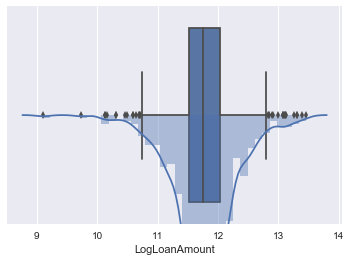

In [48]:
#converting amount to thousands
#datasetNew["LoanAmount"] = datasetNew["LoanAmount"]*1000
# sb.boxplot(datasetNew["LoanAmount"])
# datasetNew["LoanAmount"].describe()
#Distribution seems skewed having lots of outliers
#lets try a log transformation
#datasetNew["LogLoanAmount"]  =datasetNew["LoanAmount"].apply(np.log)
sb.boxplot(datasetNew["LogLoanAmount"])
datasetNew["LogLoanAmount"].describe()
#Distribution seems to have become normally distributed with equal mean and median(almost :))

# datasetNew["LoanAmount"] = datasetNew["LoanAmount"].apply(np.log)
# sb.boxplot(datasetNew["LoanAmount"])
# #let's cap the Loan Amount on 170
# datasetNew.loc[(datasetNew["LoanAmount"]>170),"LoanAmount"]=170

# sb.boxplot(datasetNew["LoanAmount"])
# datasetNew["LoanAmount"].describe()

#print datasetNew["LoanAmount"].head()

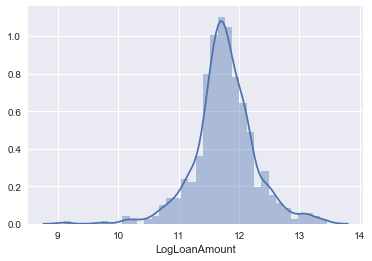

In [49]:
#now the distirbution seems like a left skewed one but follows a normal distribution
sb.distplot(datasetNew["LogLoanAmount"])

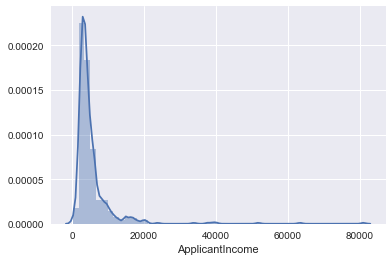

In [52]:
#Seems like a good normal distribution, still a few outliers on both axis
sb.distplot(datasetNew["ApplicantIncome"])


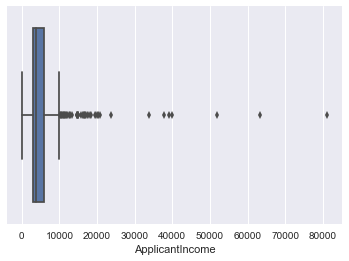

In [53]:

sb.boxplot(datasetNew["ApplicantIncome"])
#a clearly rightskewed distribution

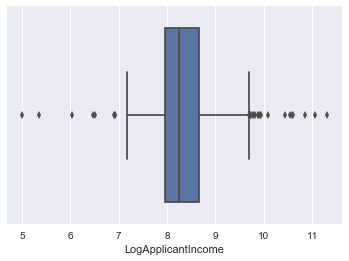

In [55]:
datasetNew["LogApplicantIncome"] =datasetNew["ApplicantIncome"].apply(np.log)
sb.boxplot(datasetNew["LogApplicantIncome"])

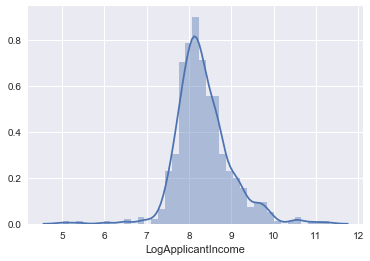

In [57]:
datasetNew["LogApplicantIncome"].describe()
sb.distplot(datasetNew["LogApplicantIncome"])

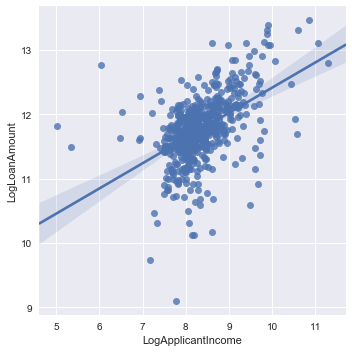

In [58]:
#plot loanamount and applicant income togather
sb.lmplot(x="LogApplicantIncome",y="LogLoanAmount",data=datasetNew)

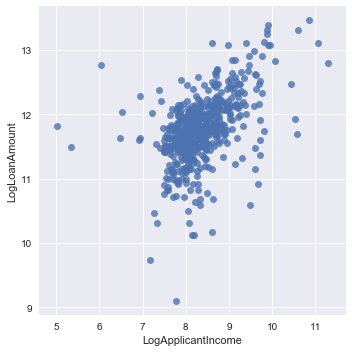

In [59]:
sb.lmplot(x="LogApplicantIncome",y="LogLoanAmount",data=datasetNew,fit_reg=False)

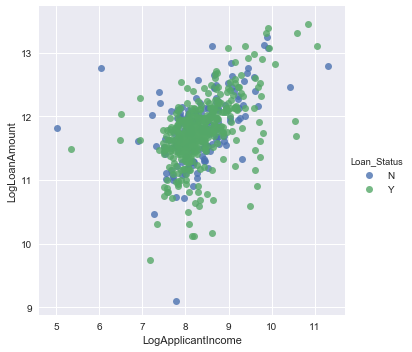

In [60]:
#except for a few oservations here and there, there is surely good corelation bw these variables
#higher the income,higher the loan amount one asks for
sb.lmplot(x="LogApplicantIncome",y="LogLoanAmount",data=datasetNew,fit_reg=False,hue="Loan_Status")

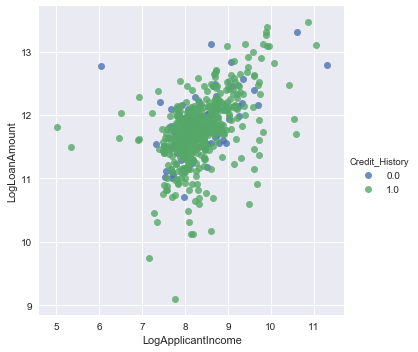

In [61]:
#upon observing according to the outcome of the loan application, it seems that there is no clear trend for any cluster 
#except for high income cases more approved cases are there as compared to rejected
# and for cases where income is high and  and loan amount is low,mostly cases got their loan approved

#lt's see the effect of some other categories

sb.lmplot(x="LogApplicantIncome",y="LogLoanAmount",data=datasetNew,fit_reg=False,hue="Credit_History")

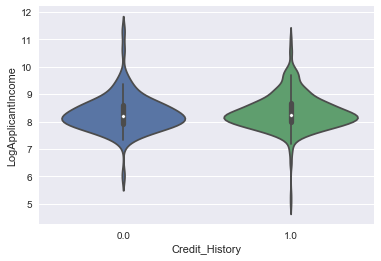

In [66]:
#can we look at the credit history through applicant income
sb.violinplot(y="LogApplicantIncome",x = "Credit_History",data=datasetNew)

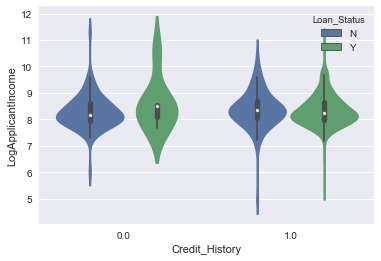

In [67]:
#though for both categories the distribution is similiar but we see that credit history is not totally dependent on person's income
#We see bad credit histry for extreme  income values while good credit history for low income groups

sb.violinplot(y="LogApplicantIncome",x = "Credit_History",data=datasetNew,hue="Loan_Status")

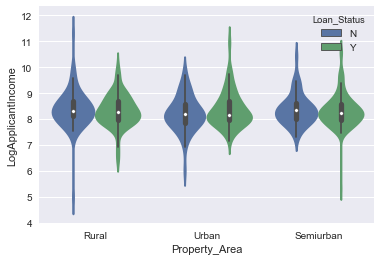

In [68]:
#We see that there is a interaction bw loanamount and Loan_Status.
#though people with good credit history  and income are also not getting the loan but we see that when you have a good credit history  you can get a loan even if you have a 
#comparatively small income
#chances of getting loan are higher with a good credit history
#please include an interaction term

sb.violinplot(y="LogApplicantIncome",x = "Property_Area",data=datasetNew,hue="Loan_Status")


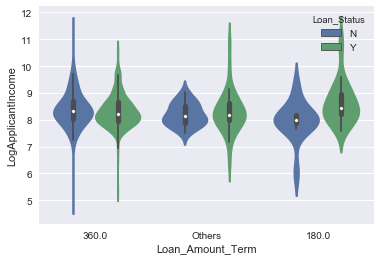

In [69]:
#please include an interaction bw property area and applicant income and credit history

sb.violinplot(y="LogApplicantIncome",x = "Loan_Amount_Term",data=datasetNew,hue="Loan_Status")

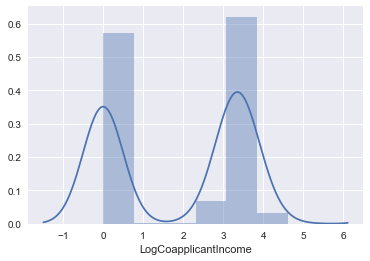

In [121]:
# sb.distplot(datasetNew["CoapplicantIncome"])
# sb.boxplot(datasetNew["CoapplicantIncome"])
# datasetNew["CoapplicantIncome"] = datasetNew["CoapplicantIncome"].astype(int)
# datasetNew["LogCoapplicantIncome"] =datasetNew["CoapplicantIncome"].apply(np.log10)
# datasetNew.loc[datasetNew["LogCoapplicantIncome"]==-np.inf,"LogCoapplicantIncome"]=0
#sb.boxplot(datasetNew["LogCoapplicantIncome"])
sb.distplot(datasetNew["LogCoapplicantIncome"])


In [122]:
print datasetNew.dtypes


Gender                   object
Married                  object
Dependents               object
Education                object
Self_Employed            object
ApplicantIncome           int64
CoapplicantIncome         int32
LoanAmount                int32
Loan_Amount_Term         object
Credit_History           object
Property_Area            object
Loan_Status              object
LogLoanAmount           float64
LogApplicantIncome      float64
LogCoapplicantIncome    float64
dtype: object


In [132]:

#converting Loan_Status to 0 0r 1
datasetNew["Loan_Status"]  =(datasetNew.Loan_Status =="N").astype(int)
#print pd.crosstab(index=datasetNew["Loan_Status"],columns="count")

col_0        count
Loan_Status       
0              411
1              181


In [134]:
datasetNew.groupby("Loan_Status").mean()

,ApplicantIncome,CoapplicantIncome,LoanAmount,LogLoanAmount,LogApplicantIncome,LogCoapplicantIncome
Loan_Status,,,,,,
0,5385.856448,1514.659367,144294.403893,11.752103,8.344896,1.935444
1,5446.193370,1933.220994,151220.994475,11.794937,8.330368,1.740896


In [135]:
datasetNew.groupby("Property_Area").mean()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Status,LogLoanAmount,LogApplicantIncome,LogCoapplicantIncome
Property_Area,,,,,,,
Rural,5502.763006,1670.208092,152260.115607,0.381503,11.828028,8.356147,2.026884
Semiurban,5280.140351,1528.600877,145504.385965,0.232456,11.769781,8.341149,1.833709
Urban,5463.340314,1753.774869,142198.952880,0.324607,11.702823,8.325411,1.789702


In [136]:
from patsy import dmatrices

In [152]:
y,X = dmatrices( "Loan_Status~Education+C(Self_Employed)+LogApplicantIncome+LogCoapplicantIncome+LogLoanAmount+C(Loan_Amount_Term)+C(Credit_History)+C(Property_Area)+Property_Area:LogApplicantIncome+LogApplicantIncome:Credit_History+Credit_History+Property_Area",datasetNew,return_type="dataframe")
print X.columns

Index([u'Intercept', u'Education[T.Not Graduate]', u'C(Self_Employed)[T.Yes]',
       u'C(Loan_Amount_Term)[T.360.0]', u'C(Loan_Amount_Term)[T.Others]',
       u'C(Credit_History)[T.1.0]', u'C(Property_Area)[T.Semiurban]',
       u'C(Property_Area)[T.Urban]', u'Credit_History[T.1.0]',
       u'Property_Area[T.Semiurban]', u'Property_Area[T.Urban]',
       u'LogApplicantIncome', u'Property_Area[T.Semiurban]:LogApplicantIncome',
       u'Property_Area[T.Urban]:LogApplicantIncome',
       u'LogApplicantIncome:Credit_History[T.1.0]', u'LogCoapplicantIncome',
       u'LogLoanAmount'],
      dtype='object')


In [153]:
#renaming column names

X = X.rename(columns={"C(Property_Area)[T.Urban]":"Property_Area_urban","C(Property_Area)[T.Semiurban]":"Property_Area_Semiurban"})
print X.columns

Index([u'Intercept', u'Education[T.Not Graduate]', u'C(Self_Employed)[T.Yes]',
       u'C(Loan_Amount_Term)[T.360.0]', u'C(Loan_Amount_Term)[T.Others]',
       u'C(Credit_History)[T.1.0]', u'Property_Area_Semiurban',
       u'Property_Area_urban', u'Credit_History[T.1.0]',
       u'Property_Area[T.Semiurban]', u'Property_Area[T.Urban]',
       u'LogApplicantIncome', u'Property_Area[T.Semiurban]:LogApplicantIncome',
       u'Property_Area[T.Urban]:LogApplicantIncome',
       u'LogApplicantIncome:Credit_History[T.1.0]', u'LogCoapplicantIncome',
       u'LogLoanAmount'],
      dtype='object')


In [154]:
y= np.ravel(y)


In [155]:

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model = model.fit(X,y)

In [156]:
model.score(X,y)

0.83445945945945943

In [157]:
y.mean()

0.30574324324324326

In [158]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test =train_test_split(X,y,test_size = 0.3,random_state=0)
model2 =LogisticRegression()
model2.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [159]:
# predict class labels for the test set
predicted = model.predict(X_test)

In [162]:

from sklearn import metrics
print metrics.accuracy_score(y_test,predicted)

0.831460674157
